# Dog Breed CNN Classification with TensorFlow

## Импорт библиотек

In [1]:
import shutil
import zipfile
import os

from google.colab import drive
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

tf.test.gpu_device_name()

'/device:GPU:0'

## Подключение GoogleDrive (Для Google Colab)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка набора данных из GoogleDrive

In [3]:
zip_file_path = '/content/drive/MyDrive/Datasets/DogBreeds.zip'
shutil.copy(zip_file_path, '/content/')

unzip_dir = '/content/DogBreeds/'
with zipfile.ZipFile('/content/DogBreeds.zip', 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(os.listdir(unzip_dir))

['train', 'labels.csv', 'sample_submission.csv', 'test']


## Предпросмотр данных

Просмотр csv-файла

In [4]:
labels_csv = pd.read_csv('/content/DogBreeds/labels.csv')
labels_csv['filepath'] = '/content/DogBreeds/train/' + labels_csv['id'] + '.jpg'
filenames = np.array(labels_csv['filepath'])
labels_csv.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/content/DogBreeds/train/000bec180eb18c7604dce...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/content/DogBreeds/train/001513dfcb2ffafc82ccc...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/content/DogBreeds/train/001cdf01b096e06d78e9e...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/content/DogBreeds/train/00214f311d5d2247d5dfe...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/content/DogBreeds/train/0021f9ceb3235effd7fcd...


Оценка количества изображений

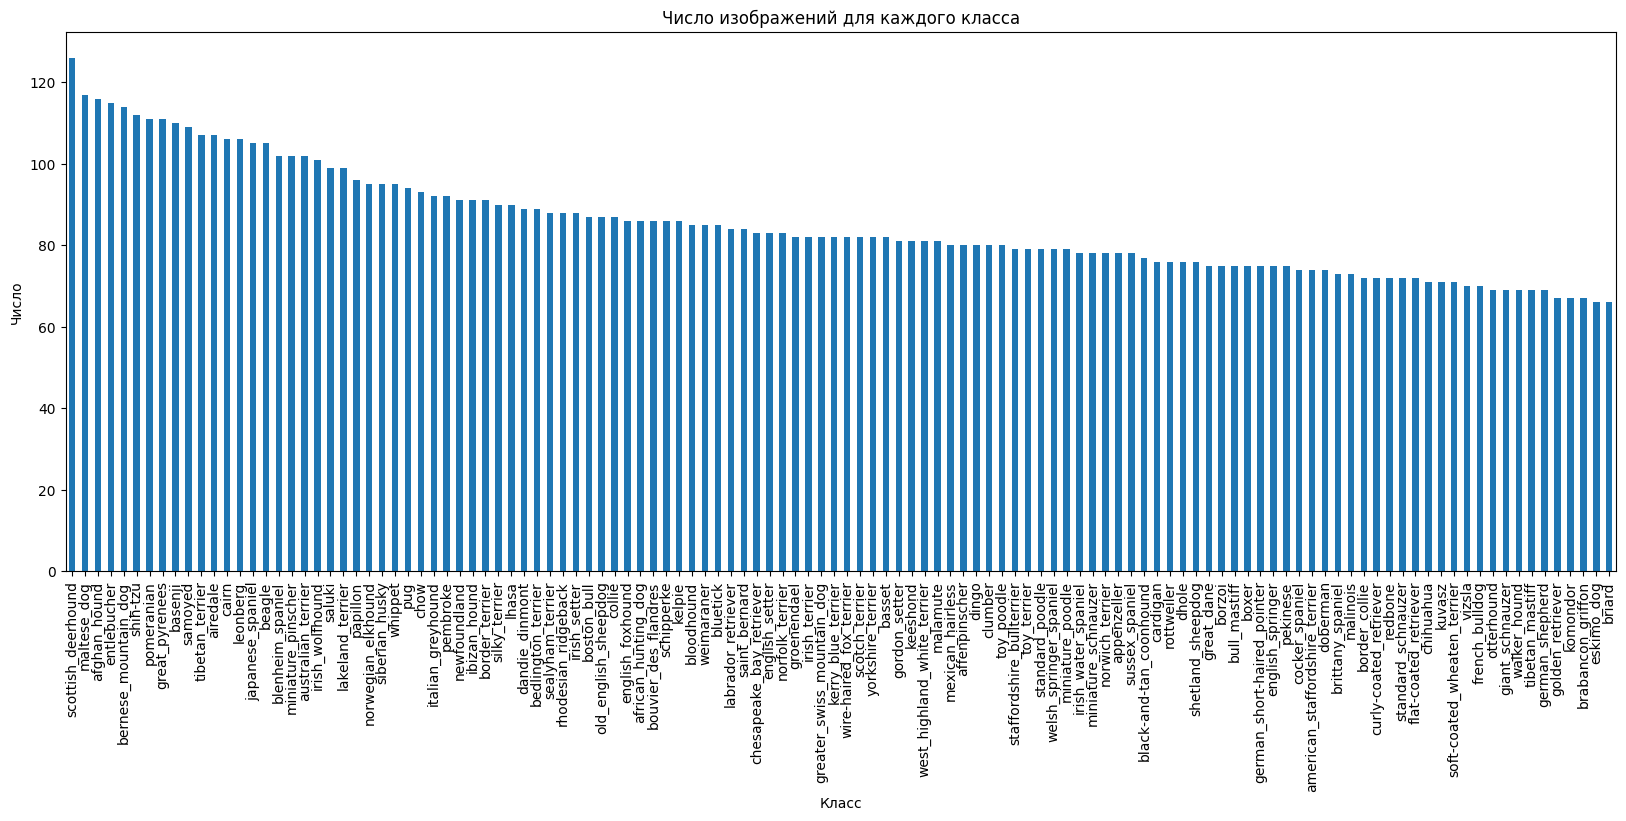

In [5]:
plt.figure(figsize=(20, 7))
labels_csv['breed'].value_counts().plot.bar()
plt.title('Число изображений для каждого класса')
plt.xlabel('Класс')
plt.ylabel('Число')
plt.show()

Предпросмотр случайных изображений

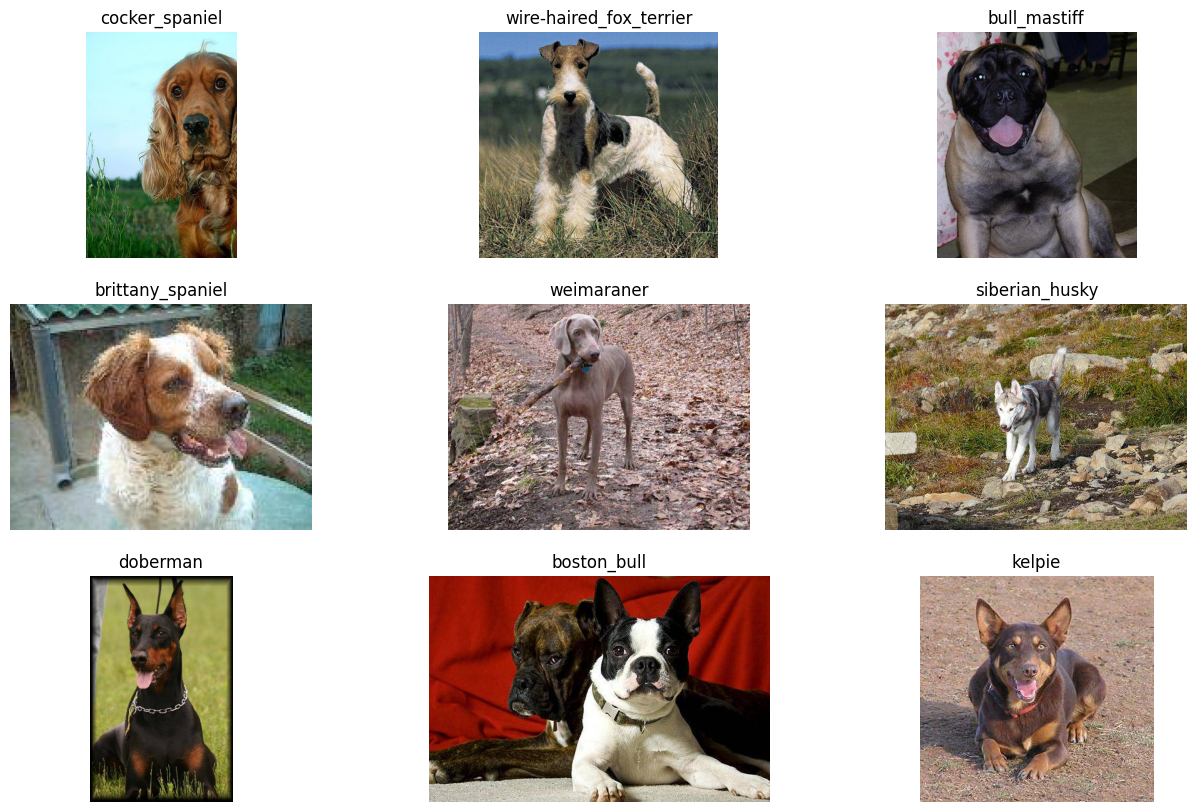

In [7]:
plt.figure(figsize=(16, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    k = np.random.randint(0, len(labels_csv))
    img = Image.open(labels_csv.loc[k, 'filepath'])
    plt.imshow(img)
    plt.title(labels_csv.loc[k, 'breed'])
    plt.axis('off')

plt.show()

## Подготовка данных

In [10]:
# Кодирование пород числами
labels = np.array(labels_csv['breed'])
unique_breeds = np.unique(labels)
labels_bool = [label == unique_breeds for label in labels]

x_train, x_val, y_train, y_val = train_test_split(filenames, labels_bool, test_size=0.2)


def process_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
    return image


def get_image_label(filepath, label):
    image = process_image(filepath)
    return image, label


def create_data_batches(x, y=None, batch_size=32, val_data=False, test_data=False):
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

    elif val_data:
        print('Creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    else:
        print('Creating train data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data = data.shuffle(buffer_size=len(x))
        data = data.map(get_image_label)
        data_batch = data.batch(batch_size)
    return data_batch


train_data = create_data_batches(x_train, y_train)
validation_data = create_data_batches(x_val, y_val, val_data=True)

Creating train data batches...
Creating validation data batches...


## Построение модели

In [44]:
conv_base = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

conv_base.trainable = True

for layer in conv_base.layers[:80]:
    layer.trainable = False

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomContrast(0.2)
])

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = conv_base(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(120, activation = 'softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 120)                 │         153,720 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 2,192,504 (8.36 MB)

 Non-trainable params: 219,200 (856.25 KB)

## Компиляция модели

In [45]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Создание обратных вызовов

In [46]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/Models/dogbreeds.keras',
        save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    )
]

## Обучение модели

In [47]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
 73/256 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.0098 - loss: 5.1923

KeyboardInterrupt: 

## Визуализация обучения

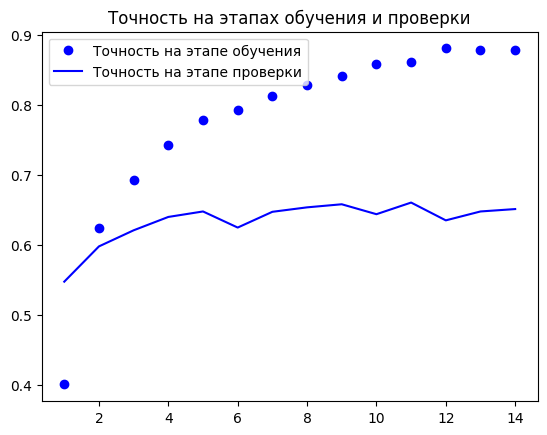

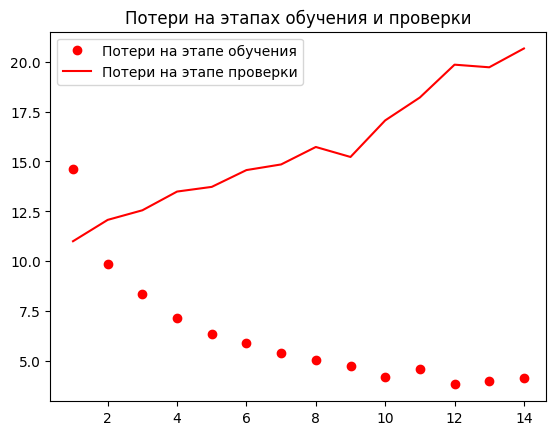

In [37]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Точность на этапе обучения')
plt.plot(epochs, val_accuracy, 'b', label='Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.legend()
plt.show()

## Тестирование модели

In [38]:
model.evaluate(validation_data)

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6485 - loss: 20.2276


[20.667118072509766, 0.6513447165489197]